# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [1]:
# |export
import pickle, gzip, math, os, time, shutil, torch, random, logging
import fastcore.all as fc, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from IPython import display
import pandas as pd
import seaborn as sns

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *


In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

mpl.rcParams["image.cmap"] = "gray_r"
logging.disable(logging.WARNING)


## Load the dataset

In [3]:
from torchvision import transforms 


denorm_image = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2)
    ])

In [4]:
xl, yl = "image", "label"
name = "fashion_mnist"
dsd = load_dataset(name)


# changed the range according to paper
@inplace
def transformi(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2))*2 -1 for o in b[xl]]


bs = 128
tds = dsd.with_transform(transformi)
# num_workers >0 on mps does funny things
dls = DataLoaders.from_dd(tds, bs, num_workers=0)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dt = dls.train
xb, yb = next(iter(dt))


In [6]:
xb.min(), xb.max()

(tensor(-1.), tensor(1.))

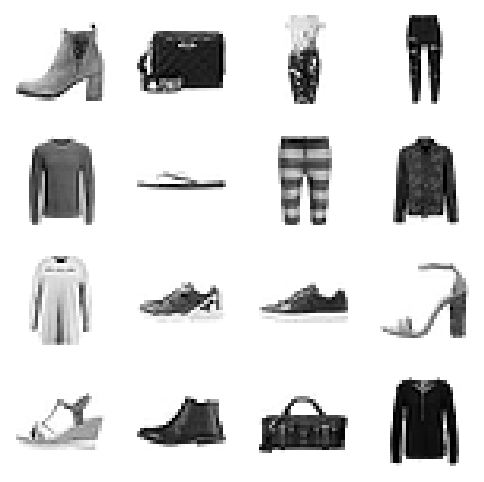

In [7]:
show_images(denorm_image(xb[:16]), imsize=1.5)

In [8]:
# ddpm

betamin, betamax, n_steps = 0.0001, 0.02, 1000

beta = torch.linspace(betamin, betamax, n_steps)

alpha = 1.0 - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [9]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1 - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε


## Training

In [10]:
from diffusers import UNet2DModel

In [11]:
# Tanishq's implementation
# comments here:
# https://forums.fast.ai/t/lesson-19-official-topic/103201/16

In [12]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t - 1] if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1


        # see also https://youtu.be/IVcl0bW3C70?t=411
        x_0_hat = (
            (x_t - b̄_t.sqrt() * model((x_t, t_batch))) / alphabar[t].sqrt()
        ).clamp(-1, 1)

        x0_coeff = ᾱ_t1.sqrt() * (1 - alpha[t]) / b̄_t
        xt_coeff = alpha[t].sqrt() * b̄_t1 / b̄_t

        x_t = x_0_hat * x0_coeff + x_t * xt_coeff + sigma[t] * z

        preds.append(x_t.cpu())
    return preds

In [13]:
coefs_data = []
for t in reversed(range(n_steps)):
    ᾱ_t1 = alphabar[t - 1] if t > 0 else torch.tensor(1)
    b̄_t = 1 - alphabar[t]
    b̄_t1 = 1 - ᾱ_t1

    x0_coeff = ᾱ_t1.sqrt() * (1 - alpha[t]) / b̄_t
    xt_coeff = alpha[t].sqrt() * b̄_t1 / b̄_t

    coefs_data.append(
        {"t": t, "x0_coeff": x0_coeff.item(), "xt_coeff": xt_coeff.item()}
    )

coeff_df = pd.DataFrame(coefs_data).set_index("t")

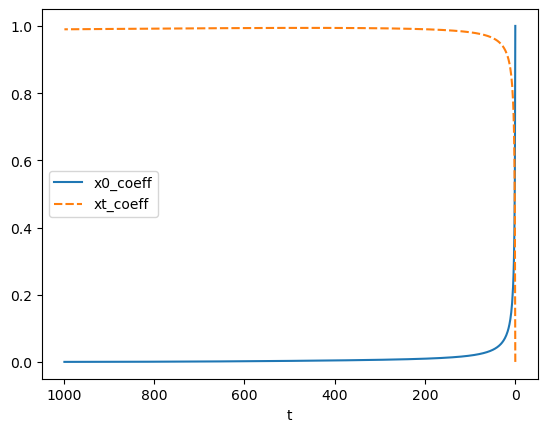

In [14]:
ax = sns.lineplot(data=coeff_df)
ax.invert_xaxis()


In [15]:
## paper impementation of alg 2


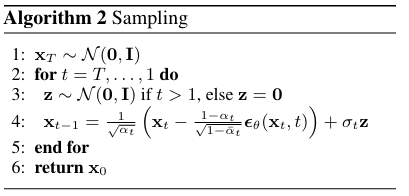

In [33]:
display.Image(
    "images/ddpm_sampling_algo_2.png"
)

Added Algorithm 2 from DDPM paper - notice how it differs from the "miniai version"



In [17]:
# my version according to paper

@torch.no_grad()
def sample_algorithm_2(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)

        noise_pred = model((x_t, t_batch))

        # line 4
        x_t_minus_1 = (1.0 / alpha[t]).sqrt() * (
            x_t - ((1 - alpha[t]) / ((1.0 - alphabar)[t].sqrt())) * noise_pred
        ) + sigma[t] * z

        x_t = x_t_minus_1

        preds.append(x_t_minus_1)
    return preds


In [18]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1

    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1.0 - self.beta
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()

    def before_batch(self, learn):
        learn.batch = noisify(learn.batch[0], self.ᾱ)

    def sample(self, model, sz):
        return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

    def sample_algorithm_2(self, model, sz):
        return sample_algorithm_2(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [19]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample


In [20]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

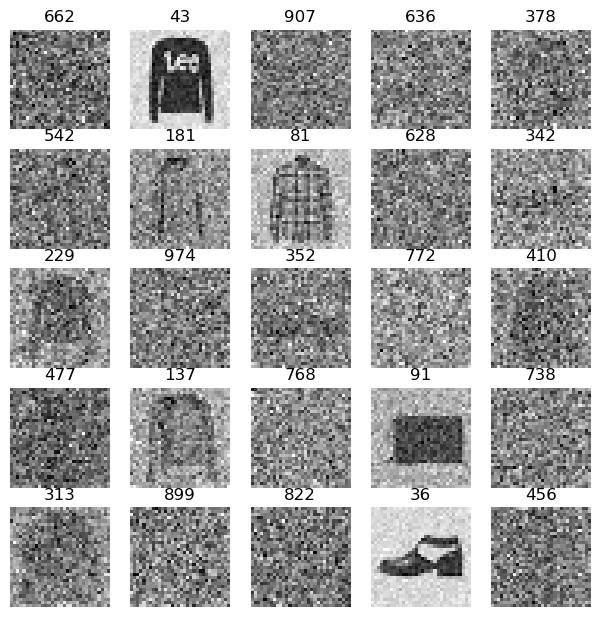

In [21]:
model = UNet(
    in_channels=1,
    out_channels=1,
    block_out_channels=(16, 32, 64, 64),
    norm_num_groups=8,
)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])
(xt, t), ε = learn.batch
show_images(denorm_image(xt[:25]), titles=fc.map_ex(t[:25], "{}"), imsize=1.5)


In [22]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [
    ddpm_cb,
    DeviceCB(device="mps"),
    ProgressCB(plot=True),
    MetricsCB(),
    BatchSchedCB(sched),
]


In [23]:
model = UNet(
    in_channels=1,
    out_channels=1,
    block_out_channels=(16, 32, 64, 128),
    norm_num_groups=8,
)


In [24]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers):
                init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()


In [25]:
init_ddpm(model)

In [26]:
opt_func = partial(optim.Adam, eps=1e-5)

In [27]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.169,0,train
0.042,0,eval
0.038,1,train
0.037,1,eval
0.034,2,train
0.032,2,eval
0.031,3,train
0.032,3,eval
0.030,4,train
0.032,4,eval


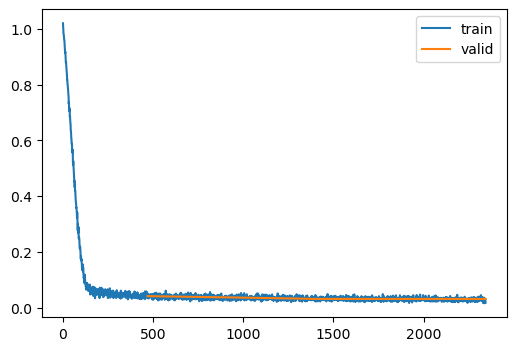

In [28]:
learn.fit(epochs)

In [34]:
mdl_path = Path("models")

In [35]:
torch.save(learn.model, mdl_path / "fashion_ddpm2.pkl")

In [36]:
learn.model = torch.load(mdl_path / "fashion_ddpm2.pkl").to("mps")

## Sampling

In [37]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

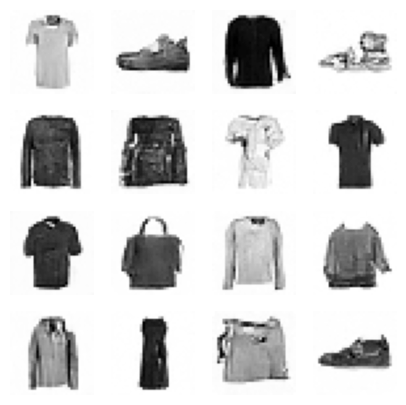

In [39]:
show_images(denorm_image(samples[-1]), figsize=(5, 5))

In [40]:
samples_algorithm_2 = ddpm_cb.sample_algorithm_2(learn.model, (16, 1, 32, 32))

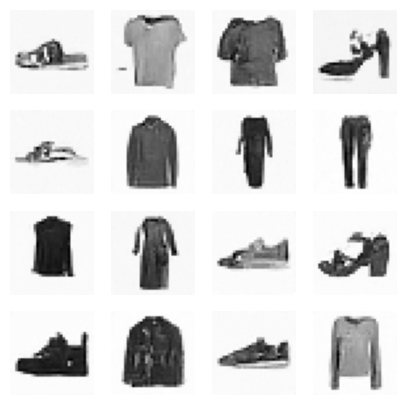

In [42]:
show_images(denorm_image(samples_algorithm_2[-1]), figsize=(5, 5))